## IMPORT LIBRARIES AND DATASET

In [1]:
import pandas as pd
import numpy as np 

from matplotlib import pyplot as plt 
import seaborn as sns

from imblearn.over_sampling import SMOTE

from sklearn.model_selection import StratifiedKFold, GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import accuracy_score, roc_curve, auc


In [2]:
# Import dataset after EDA (without normalization)
#df = pd.read_csv('dataset_after_eda/Dataset_after_eda.csv', sep=',')

# Import Normalized dataset after EDA
df = pd.read_csv('dataset_after_eda/Normalized_dataset_after_eda.csv', sep=',')

## UNBALANCED ISSUE

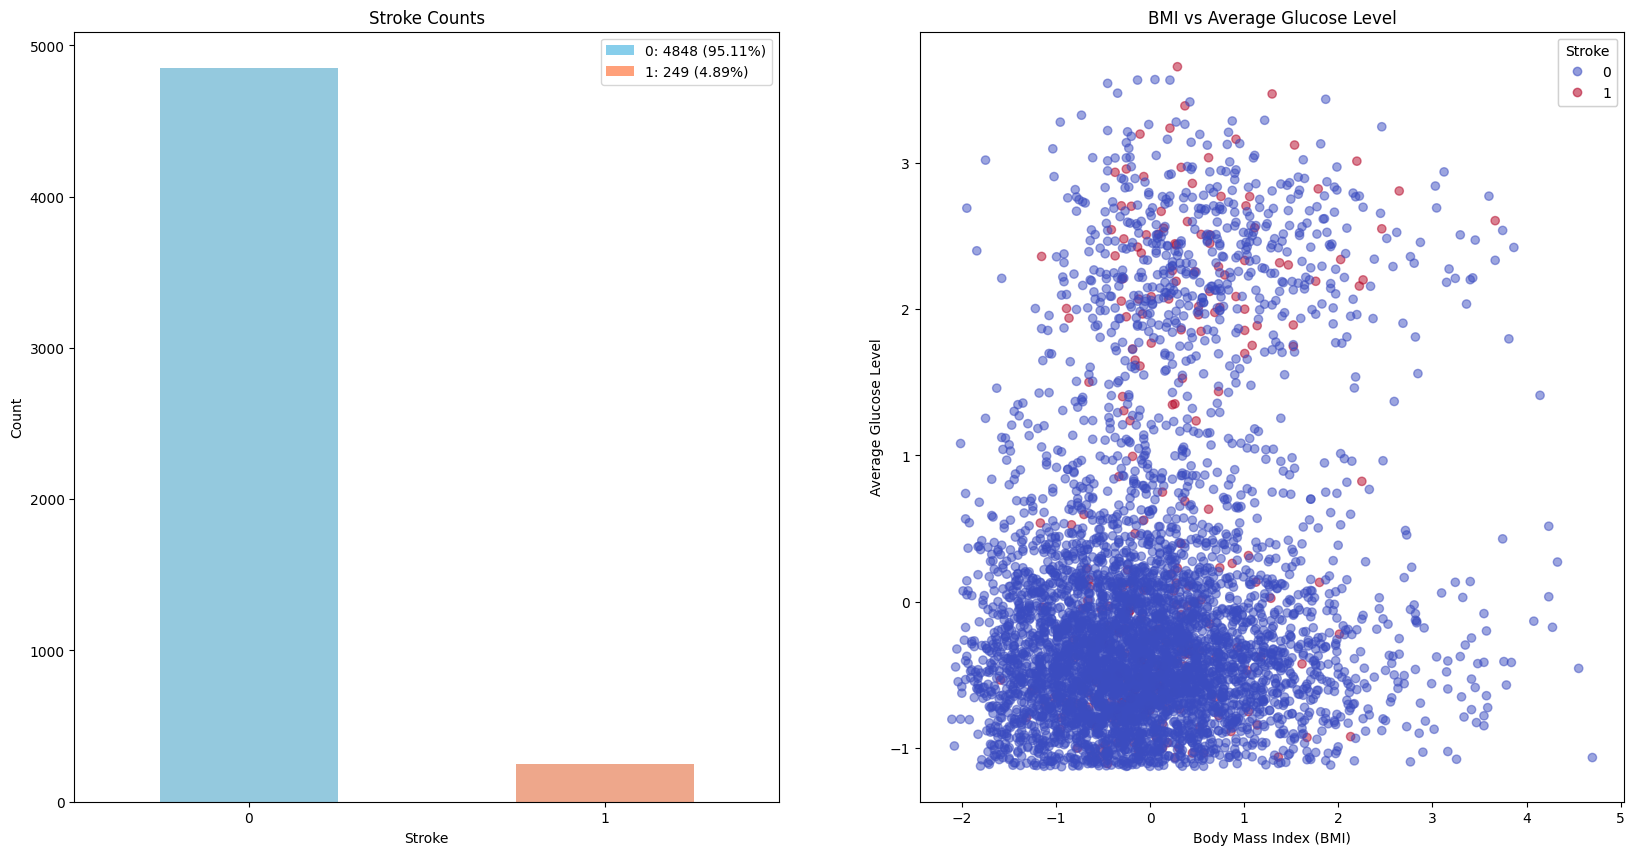

In [3]:
# Count Plot for stroke
# Create a scatter plot with points colored according to the stroke feature

# Calculate counts for each option
counts = df['stroke'].value_counts()

# Define colors for each option
colors = {0: 'skyblue', 1: 'lightsalmon'}

fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (20,10))

sns.countplot(df, x='stroke',hue='stroke', palette=colors.values(), legend=False, width=0.5, ax=axes[0])
axes[0].set_xlabel('Stroke')
axes[0].set_ylabel('Count')
axes[0].set_title('Stroke Counts')

# Add Legend
for i, (count, color) in enumerate(zip(counts, colors.values())):
    axes[0].bar(i, 0, color=color, label=f'{i}: {count} ({(count/df.shape[0]*100):.2f}%)')

axes[0].legend(loc='upper right')

scatter = axes[1].scatter(df['bmi'], df['avg_glucose_level'], c=df['stroke'], cmap='coolwarm', alpha=0.5)

legend1 = axes[1].legend(*scatter.legend_elements(), title='Stroke')
axes[1].add_artist(legend1)

axes[1].set_title('BMI vs Average Glucose Level')
axes[1].set_xlabel('Body Mass Index (BMI)')
axes[1].set_ylabel('Average Glucose Level')

plt.show()

In [4]:
# Target is 'stroke' which has two values 0 and 1

X = df.drop('stroke', axis=1)
y = df['stroke']

print(f'Entire Dataset Shape:{X.shape}')
print(f'Entire Target Shape:{y.shape}')

# Apply SMOTE to balance the classes
smote = SMOTE(random_state=59)
X_smote, y_smote = smote.fit_resample(X, y)

print(f'New Feature Shape:{X_smote.shape}')
print(f'New Target Shape:{y_smote.shape}')

Entire Dataset Shape:(5097, 10)
Entire Target Shape:(5097,)
New Feature Shape:(9696, 10)
New Target Shape:(9696,)


Text(0, 0.5, 'Average Glucose Level')

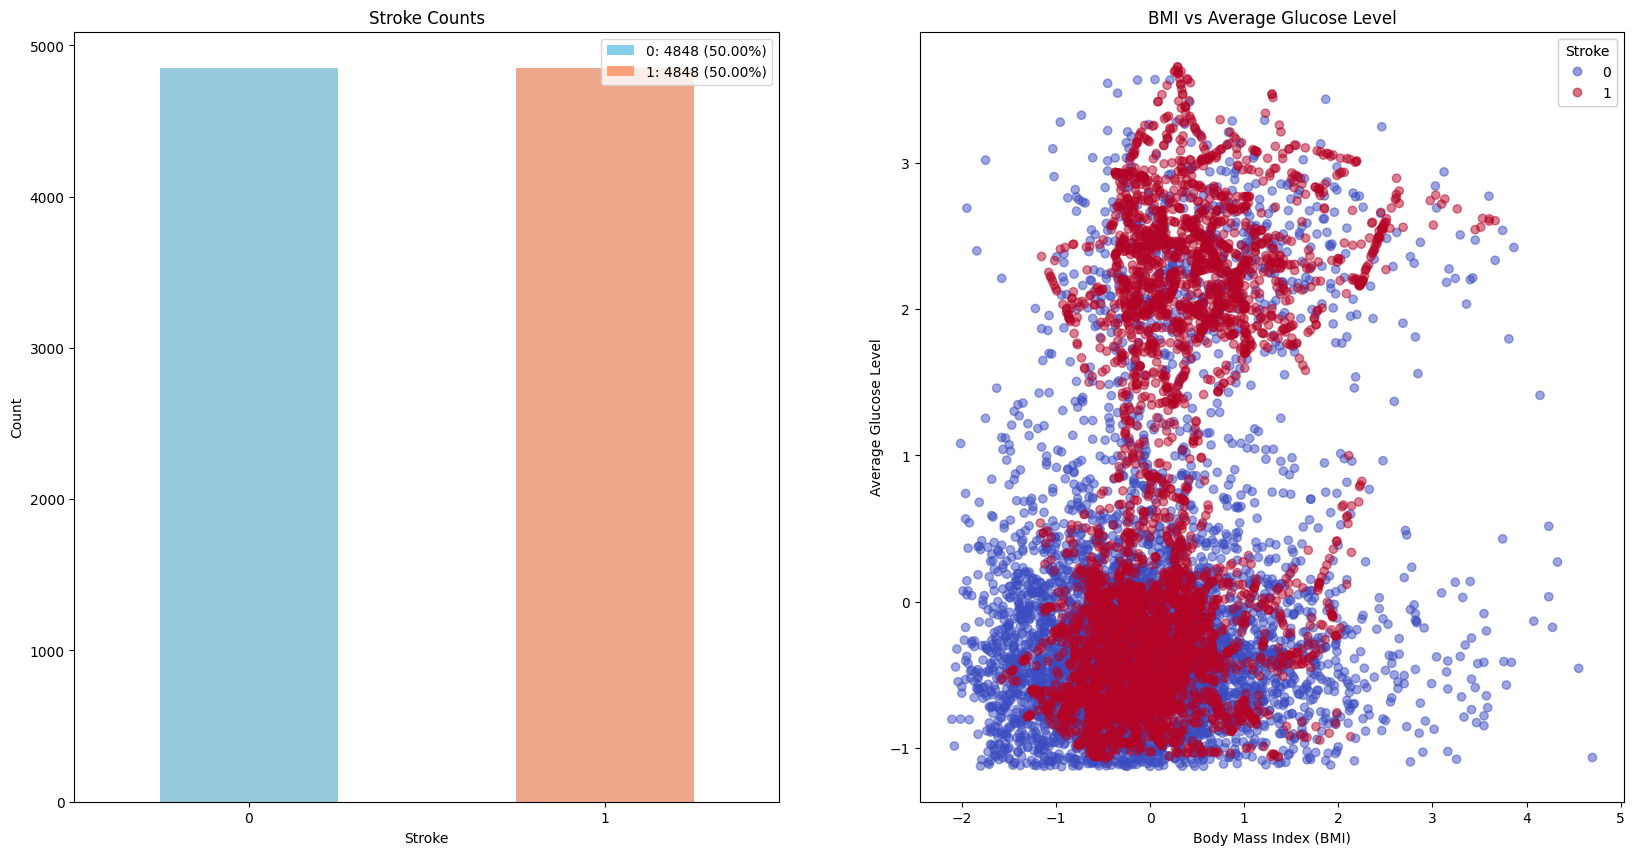

In [5]:
# Unbalanced issue [SOLVED]

# Balanced df
df_balanced = pd.DataFrame()
df_balanced[X.columns] = X_smote
df_balanced['stroke'] = y_smote

# Calculate counts for each option
counts = df_balanced['stroke'].value_counts()

# Define colors for each option
colors = {0: 'skyblue', 1: 'lightsalmon'}

fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (20,10))

sns.countplot(df_balanced, x='stroke',hue='stroke', palette=colors.values(), legend=False, width=0.5, ax=axes[0])
axes[0].set_xlabel('Stroke')
axes[0].set_ylabel('Count')
axes[0].set_title('Stroke Counts')

# Add Legend
for i, (count, color) in enumerate(zip(counts, colors.values())):
    axes[0].bar(i, 0, color=color, label=f'{i}: {count} ({(count/df_balanced.shape[0]*100):.2f}%)')

axes[0].legend(loc='upper right')

scatter = axes[1].scatter(df_balanced['bmi'], df_balanced['avg_glucose_level'], c=df_balanced['stroke'], cmap='coolwarm', alpha=0.5)

legend1 = axes[1].legend(*scatter.legend_elements(), title='Stroke')
axes[1].add_artist(legend1)

axes[1].set_title('BMI vs Average Glucose Level')
axes[1].set_xlabel('Body Mass Index (BMI)')
axes[1].set_ylabel('Average Glucose Level')

## CROSS-VALIDATION PREDICTION

In [6]:
# Define machine learning classifier with defauld parameters

models = [
    ('Logistic Regression', LogisticRegression(max_iter=1000)),
    ('Decision Tree', DecisionTreeClassifier()),
    ('Random Forest', RandomForestClassifier()),
    ('Gradient Boosting', GradientBoostingClassifier()),
    ('eXtreme Gradient Boosting', XGBClassifier()),
    ('Support Vector Machine', SVC(probability=True)),
    ('K-nearest neighbors', KNeighborsClassifier()),
    ('Naive Bayes', GaussianNB())
]

print(f'Evaluation using {len(models)} Machine Learning Classifiers')

Evaluation using 8 Machine Learning Classifiers


In [7]:
# Perform iterated 10-fold stratified cross-validation for each model

# DF to save results
results_test_iter = pd.DataFrame()
results_train_iter = pd.DataFrame()
results_test = pd.DataFrame()
results_train = pd.DataFrame()

# DF to store confusion matrix and ROC results
test_confusion = pd.DataFrame()
train_confusion = pd.DataFrame()
roc = pd.DataFrame()

# Number of iterations
num_iter = 5

for name, model in models:

    print(f'Evaluating model: {name}...')

    # Define dict for each metric for both test and train predictions
    test_metrics = {
        'Accuracy' : [],
        'Precision' : [],
        'Recall' : [],
        'F1 Score' : [],
        'AUC' : []
    }

    train_metrics = {
        'Accuracy' : [],
        'Precision' : [],
        'Recall' : [],
        'F1 Score' : [],
        'AUC' : []
    }

    test_confusion_matrices = []
    train_confusion_matrices = []
    roc_auc_curves = []

    for i in range(0,num_iter):

        # Set up stratified CV
        stratified_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state= i)
        
        for train_index, test_index in stratified_cv.split(X_smote, y_smote):

            X_train_fold, X_test_fold = X_smote.iloc[train_index], X_smote.iloc[test_index]
            y_train_fold, y_test_fold = y_smote.iloc[train_index], y_smote.iloc[test_index]

            model.fit(X_train_fold, y_train_fold)
            
            # predictions
            y_pred_fold = model.predict(X_test_fold)
            y_pred_train = model.predict(X_train_fold)

            # metrics calculation for test
            test_metrics['Accuracy'].append(accuracy_score(y_test_fold, y_pred_fold))
            test_metrics['Precision'].append(precision_score(y_test_fold, y_pred_fold))
            test_metrics['Recall'].append(recall_score(y_test_fold, y_pred_fold))
            test_metrics['F1 Score'].append(f1_score(y_test_fold, y_pred_fold))
            test_metrics['AUC'].append(roc_auc_score(y_test_fold, y_pred_fold))
            
            # metrics calculation for train
            train_metrics['Accuracy'].append(accuracy_score(y_train_fold, y_pred_train))
            train_metrics['Precision'].append(precision_score(y_train_fold, y_pred_train))
            train_metrics['Recall'].append(recall_score(y_train_fold, y_pred_train))
            train_metrics['F1 Score'].append(f1_score(y_train_fold, y_pred_train))
            train_metrics['AUC'].append(roc_auc_score(y_train_fold, y_pred_train))

            # Calculate confusion matrices
            test_confusion_matrices.append(confusion_matrix(y_test_fold, y_pred_fold))
            train_confusion_matrices.append(confusion_matrix(y_train_fold, y_pred_train))

            # Calculate ROC curve
            fpr, tpr, _ = roc_curve(y_test_fold, model.predict_proba(X_test_fold)[:, 1])
            roc_auc_curves.append((fpr, tpr))

    # Collecting metric values for eahc iteration for each model (both train and test)
    metric_test_iter = {
        metric : value for metric, value in test_metrics.items()
    }
    cols_iter = pd.MultiIndex.from_product([[name], [str(j) for j in range(0,num_iter*10)]])
    results_test_iter_medium = pd.DataFrame(metric_test_iter.values(), columns=cols_iter)
    results_test_iter = pd.concat([results_test_iter, results_test_iter_medium], axis=1)

    metric_train_iter = {
        metric : value for metric, value in train_metrics.items()
    }
    results_train_iter_medium = pd.DataFrame(metric_train_iter.values(), columns=cols_iter)
    results_train_iter = pd.concat([results_train_iter, results_train_iter_medium], axis=1)

    # Collecting mean and std values for each metric and for each model (both train and test)
    mean_folds_metrics = {
        metric : (np.mean(value), np.std(value)) for metric, value in test_metrics.items()
    }

    cols = pd.MultiIndex.from_product([[name], ['Mean', 'Std']])

    res_test_medium = pd.DataFrame(mean_folds_metrics.values(), columns=cols)
    results_test = pd.concat([results_test, res_test_medium], axis=1)

    mean_train_metrics = {
        metric : (np.mean(value), np.std(value)) for metric, value in train_metrics.items()
    }

    res_train_medium = pd.DataFrame(mean_train_metrics.values(), columns=cols)
    results_train = pd.concat([results_train, res_train_medium], axis=1)

    # Save confusion matrices and ROC curves
    test_confusion[name] = test_confusion_matrices
    train_confusion[name] = train_confusion_matrices
    roc[name] = roc_auc_curves 

# Use metrics names as rows index
results_test.index = mean_folds_metrics.keys()
results_train.index = mean_train_metrics.keys()
results_test_iter.index = metric_test_iter.keys()
results_train_iter.index = metric_train_iter.keys()

Evaluating model: Logistic Regression...
Evaluating model: Decision Tree...
Evaluating model: Random Forest...
Evaluating model: Gradient Boosting...
Evaluating model: eXtreme Gradient Boosting...
Evaluating model: Support Vector Machine...
Evaluating model: K-nearest neighbors...
Evaluating model: Naive Bayes...


In [8]:
# Show test results for each classifier and each metric (mean and std)
results_test

Logistic Regression           Decision Tree           Random Forest  \
                         Mean       Std          Mean       Std          Mean   
Accuracy             0.780529  0.012533      0.893441  0.011055      0.939954   
Precision            0.760581  0.012997      0.883393  0.014766      0.914387   
Recall               0.819142  0.020788      0.906849  0.014284      0.970959   
F1 Score             0.788622  0.012858      0.894860  0.010749      0.941777   
AUC                  0.780527  0.012537      0.893442  0.011054      0.939954   

                    Gradient Boosting           eXtreme Gradient Boosting  \
                Std              Mean       Std                      Mean   
Accuracy   0.007337          0.848762  0.009023                  0.931476   
Precision  0.010572          0.818265  0.011123                  0.919585   
Recall     0.008429          0.896986  0.016218                  0.945790   
F1 Score   0.006964          0.855695  0.008838                  0.932449   
AUC        0.007345          0.848760  0.009025                  0.931476   

                    Support Vector Machine           K-nearest neighbors  \
                Std                   Mean       Std                Mean   
Accuracy   0.007258               0.829868  0.010191            0.886798   
Precision  0.010437               0.787376  0.011896            0.826045   
Recall     0.009679               0.904165  0.015151            0.980240   
F1 Score   0.007086               0.841630  0.009358            0.896516   
AUC        0.007257               0.829866  0.010198            0.886798   

                    Naive Bayes            
                Std        Mean       Std  
Accuracy   0.008845    0.750187  0.011260  
Precision  0.011471    0.724847  0.012207  
Recall     0.005378    0.806975  0.016748  
F1 Score   0.007459    0.763589  0.010662  
AUC        0.008854    0.750188  0.011270

In [9]:
# Show train results for each classifier and each metric (mean and std)
results_train

Logistic Regression           Decision Tree      Random Forest  \
                         Mean       Std          Mean  Std          Mean   
Accuracy             0.781236  0.001346           1.0  0.0      0.999995   
Precision            0.760987  0.001343           1.0  0.0      0.999995   
Recall               0.820031  0.001723           1.0  0.0      0.999995   
F1 Score             0.789406  0.001314           1.0  0.0      0.999995   
AUC                  0.781236  0.001347           1.0  0.0      0.999995   

                    Gradient Boosting           eXtreme Gradient Boosting  \
                Std              Mean       Std                      Mean   
Accuracy   0.000022          0.863967  0.002123                  0.987168   
Precision  0.000032          0.832339  0.002367                  0.983602   
Recall     0.000032          0.911560  0.003257                  0.990860   
F1 Score   0.000022          0.870146  0.002061                  0.987216   
AUC        0.000022          0.863967  0.002123                  0.987168   

                    Support Vector Machine           K-nearest neighbors  \
                Std                   Mean       Std                Mean   
Accuracy   0.001717               0.836134  0.001371            0.916813   
Precision  0.002597               0.793645  0.001878            0.863632   
Recall     0.001719               0.908494  0.002775            0.989943   
F1 Score   0.001703               0.847191  0.001287            0.922483   
AUC        0.001717               0.836134  0.001372            0.916813   

                    Naive Bayes            
                Std        Mean       Std  
Accuracy   0.001057    0.750532  0.001072  
Precision  0.001519    0.724916  0.001365  
Recall     0.000848    0.807485  0.002304  
F1 Score   0.000928    0.763973  0.001073  
AUC        0.001058    0.750532  0.001073

In [10]:
# Show train results for each classifier and each metric (over every iterations)
results_train_iter

Logistic Regression                                          \
                            0         1         2         3         4   
Accuracy             0.780770  0.781916  0.780083  0.782833  0.782375   
Precision            0.760971  0.761257  0.759669  0.762777  0.762463   
Recall               0.818703  0.821453  0.819390  0.820995  0.820307   
F1 Score             0.788782  0.790211  0.788400  0.790816  0.790328   
AUC                  0.780770  0.781916  0.780083  0.782833  0.782375   

                                                             ... Naive Bayes  \
                  5         6         7         8         9  ...          40   
Accuracy   0.781916  0.779306  0.782972  0.781024  0.781139  ...    0.749713   
Precision  0.761036  0.759090  0.762046  0.760902  0.761732  ...    0.723671   
Recall     0.821912  0.818244  0.822828  0.819661  0.818286  ...    0.807930   
F1 Score   0.790303  0.787558  0.791272  0.789189  0.788997  ...    0.763483   
AUC        0.781916  0.779310  0.782977  0.781020  0.781135  ...    0.749713   

                                                                       \
                 41        42        43        44        45        46   
Accuracy   0.750630  0.751203  0.751089  0.750630  0.750516  0.751117   
Precision  0.725046  0.725144  0.725551  0.725603  0.725640  0.723344   
Recall     0.807472  0.809076  0.807701  0.806097  0.805638  0.813202   
F1 Score   0.764043  0.764814  0.764425  0.763735  0.763549  0.765645   
AUC        0.750630  0.751203  0.751089  0.750630  0.750516  0.751124   

                                         
                 47        48        49  
Accuracy   0.750544  0.750659  0.749055  
Precision  0.725361  0.725846  0.723387  
Recall     0.806326  0.805683  0.806599  
F1 Score   0.763703  0.763684  0.762730  
AUC        0.750551  0.750653  0.749048  

[5 rows x 400 columns]

## RESULTS VISUALIZATION

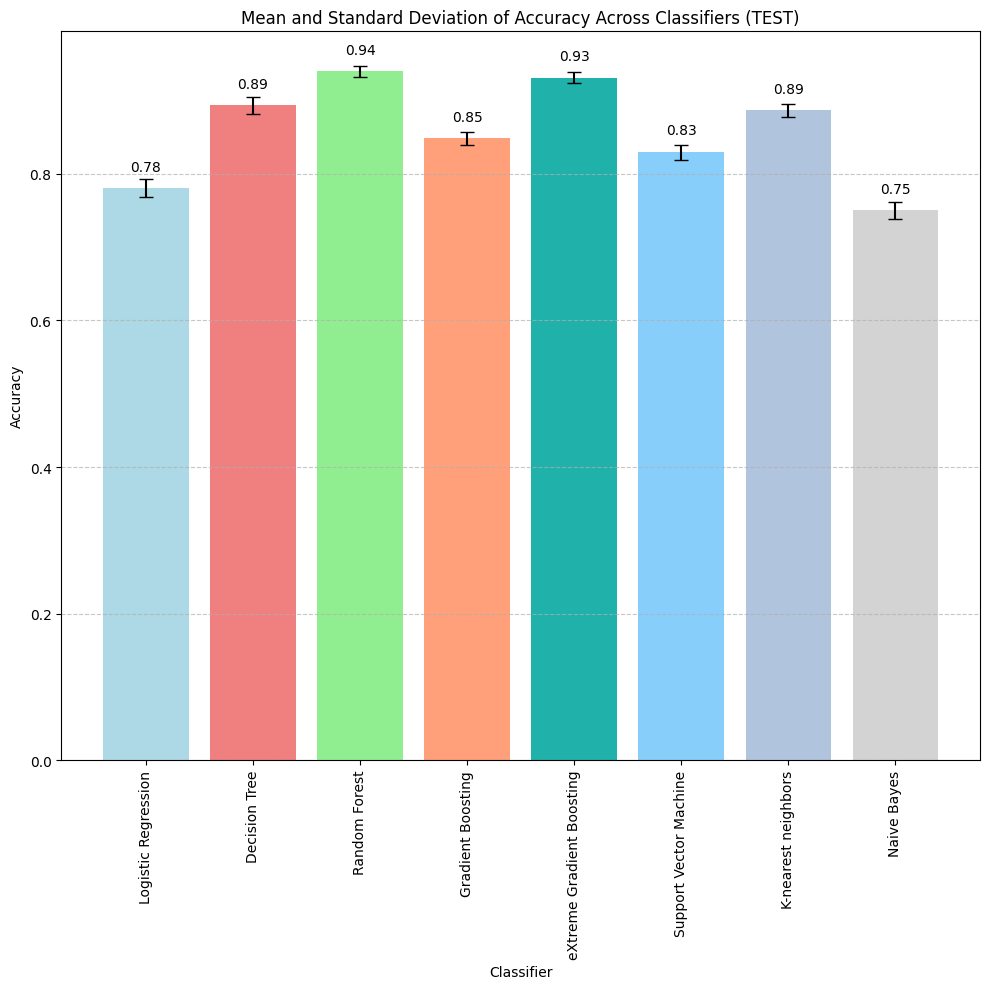

In [13]:
#  Bar plot for each classifiers to visualize one of the evaluation metrics with mean and std values (using TEST results)

classifiers = ['Logistic Regression', 'Decision Tree', 'Random Forest', 'Gradient Boosting', 
               'eXtreme Gradient Boosting', 'Support Vector Machine', 'K-nearest neighbors', 'Naive Bayes']

metric = 'Accuracy'

# Define colors for each bar
light_colors = ['lightblue', 'lightcoral', 'lightgreen', 'lightsalmon', 'lightseagreen', 'lightskyblue', 'lightsteelblue', 'lightgrey']

plt.figure(figsize=(10, 10))

bars = plt.bar(classifiers, results_test.loc[:, (slice(None), 'Mean')].loc[metric], 
               yerr = results_test.loc[:, (slice(None), 'Std')].loc[metric],
                capsize=5, color=light_colors)

# Annotate each bar with its mean value
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 0.02, round(height, 2),
             ha='center', va='bottom')

plt.xlabel('Classifier')
plt.ylabel(metric)
plt.title(f'Mean and Standard Deviation of {metric} Across Classifiers (TEST)')
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


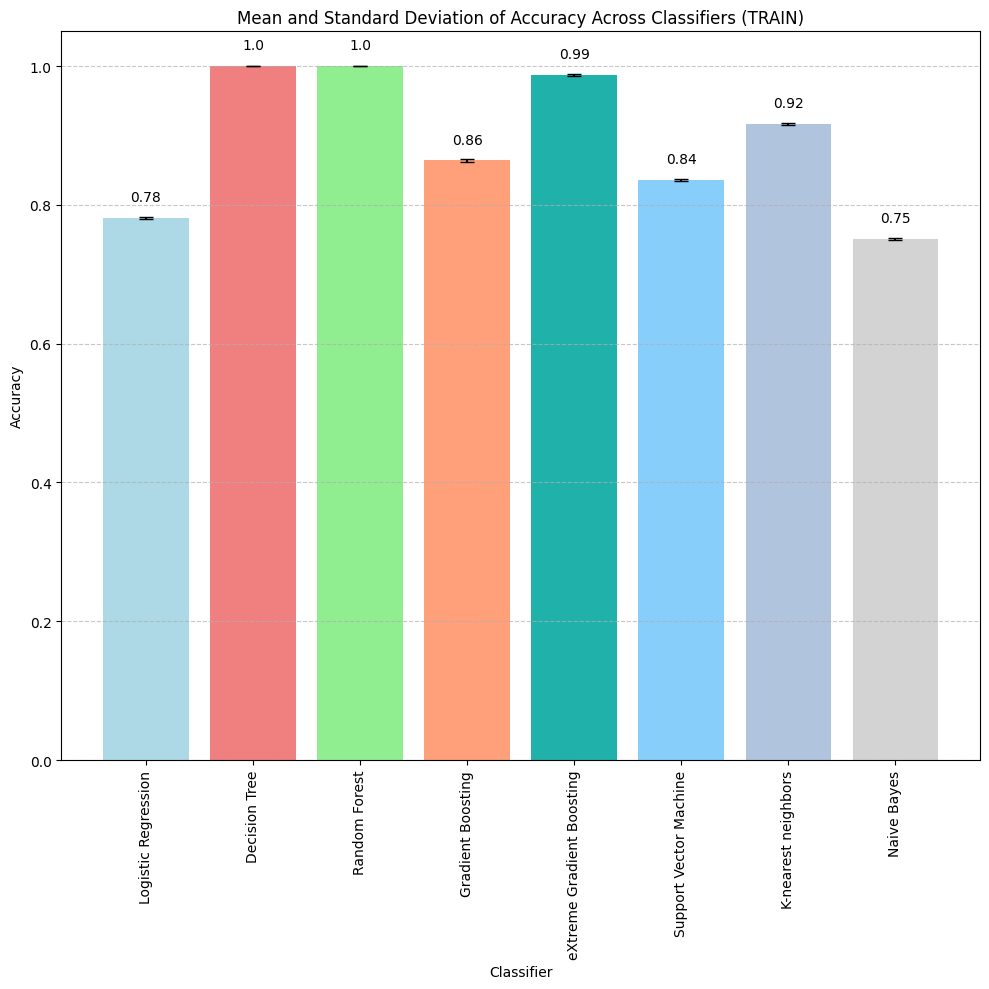

In [14]:
#  Bar plot for each classifiers to visualize one of the evaluation metrics with mean and std values (using TRAIN results)

classifiers = ['Logistic Regression', 'Decision Tree', 'Random Forest', 'Gradient Boosting', 
               'eXtreme Gradient Boosting', 'Support Vector Machine', 'K-nearest neighbors', 'Naive Bayes']

metric = 'Accuracy'

# Define colors for each bar
light_colors = ['lightblue', 'lightcoral', 'lightgreen', 'lightsalmon', 'lightseagreen', 'lightskyblue', 'lightsteelblue', 'lightgrey']

plt.figure(figsize=(10, 10))

bars = plt.bar(classifiers, results_train.loc[:, (slice(None), 'Mean')].loc[metric], 
               yerr=results_train.loc[:, (slice(None), 'Std')].loc[metric], capsize=5, color=light_colors)

# Annotate each bar with its mean value
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 0.02, round(height, 2),
             ha='center', va='bottom')

plt.xlabel('Classifier')
plt.ylabel(metric)
plt.title(f'Mean and Standard Deviation of {metric} Across Classifiers (TRAIN)')
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

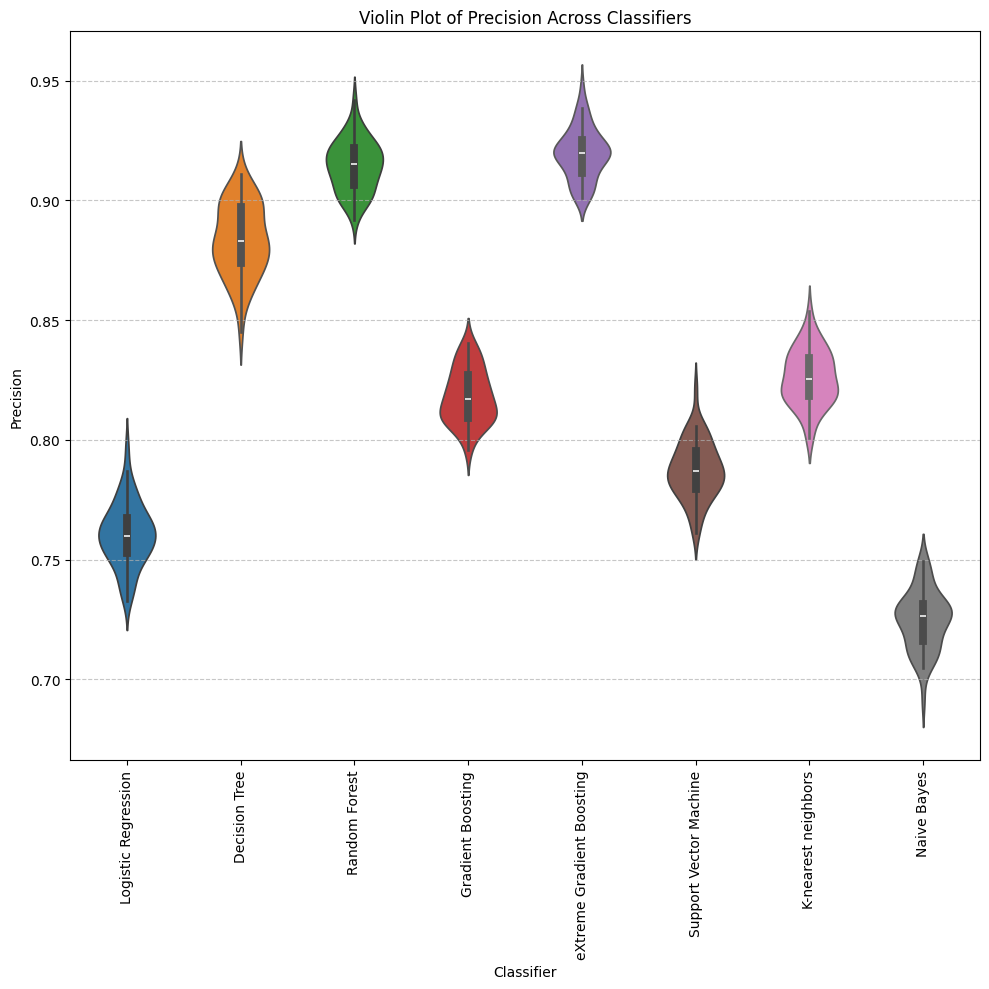

In [15]:
# Violin Plot for the iteration values (using TEST results)

classifiers = ['Logistic Regression', 'Decision Tree', 'Random Forest', 'Gradient Boosting', 
               'eXtreme Gradient Boosting', 'Support Vector Machine', 'K-nearest neighbors', 'Naive Bayes']

metric = 'Precision'

plt.figure(figsize=(10, 10))

for classifier in classifiers:
    data_df = pd.DataFrame(results_test_iter.loc[:, (classifier, [str(j) for j in range(0,num_iter*10)])].loc[metric])

    sns.violinplot(x=data_df.index.get_level_values(0), y = metric, data=data_df, width=0.5)

plt.xlabel('Classifier')
plt.ylabel(metric)
plt.title(f'Violin Plot of {metric} Across Classifiers')
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

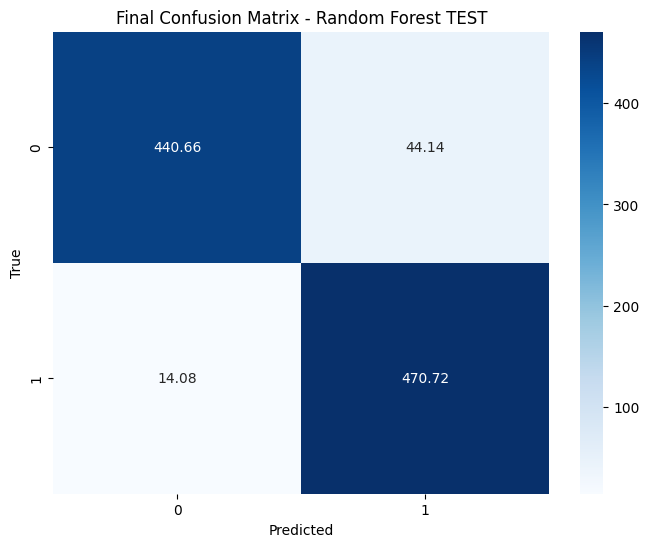

In [17]:
# Display final confusion matrix for each model (using TEST results)

model_name = 'Random Forest'
confusion_matrix_mean = np.mean(test_confusion[model_name], axis=0)

plt.figure(figsize=(8, 6))

sns.heatmap(confusion_matrix_mean, annot=True, cmap='Blues', fmt='g')

plt.title(f'Final Confusion Matrix - {model_name} TEST')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

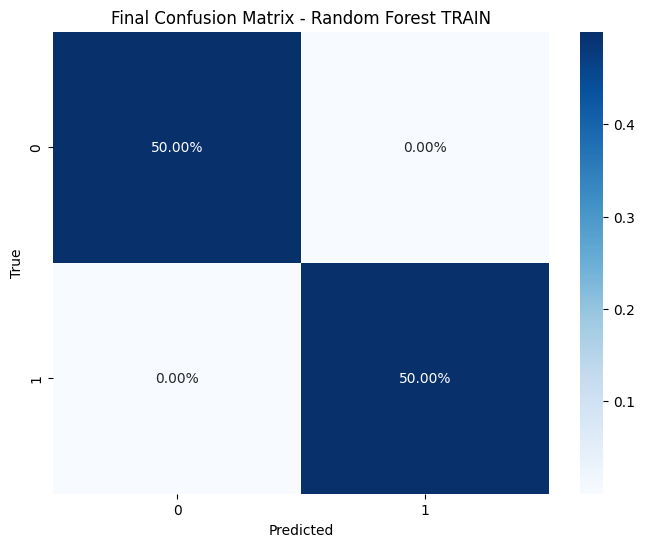

In [19]:
# Display final confusion matrix for each model (using TRAIN results)

model_name = 'Random Forest'
confusion_matrix_mean = np.mean(train_confusion[model_name], axis=0)

plt.figure(figsize=(8, 6))

#sns.heatmap(confusion_matrix_mean, annot=True, cmap='Blues', fmt='g')

# If you prefer percentage information
sns.heatmap(confusion_matrix_mean/np.sum(confusion_matrix_mean), annot=True, cmap='Blues', fmt='.2%')

plt.title(f'Final Confusion Matrix - {model_name} TRAIN')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

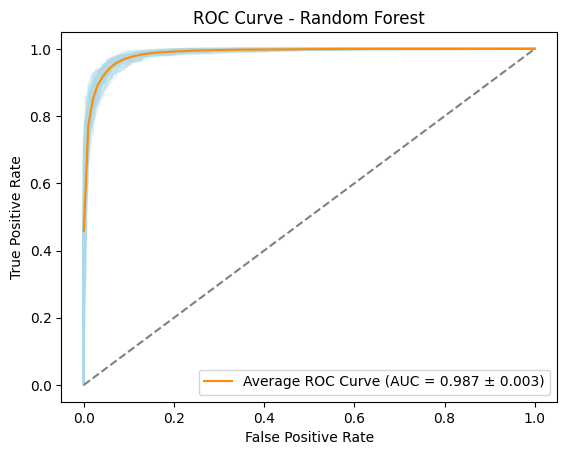

In [20]:
# Display Average ROC curve and curves for each iteration, for each model (using TEST results)

model_name = 'Random Forest'

mean_fpr = np.linspace(0, 1, 100)
tprs = []
auc_scores = []
for curve in roc[model_name]:
        
        # Calculate AUC for each ROC curve 
        auc_score = auc(curve[0], curve[1])
        auc_scores.append(auc_score)
        
        #auc_std = np.std(auc_scores)
        
        plt.plot(curve[0], curve[1], color='lightblue', alpha=0.3)

        tprs.append(np.interp(mean_fpr, curve[0], curve[1]))

auc_std = np.std(auc_scores)
mean_tpr = np.mean(tprs, axis=0)

#plt.plot(mean_fpr, mean_tpr, color='darkorange', label=f'Average ROC Curve (AUC = {auc(mean_fpr, mean_tpr):.3f} ± {auc_std:.3f})')
plt.plot(mean_fpr, mean_tpr, color='darkorange', label=f'Average ROC Curve (AUC = {np.mean(auc_scores):.3f} ± {auc_std:.3f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='grey')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve - {model_name}')
plt.legend(loc="lower right")
plt.show()

## HYPERPARAMETERS TUNING

In [22]:
# After the evaluation on the best classifier with default parameters, I found out that the best classifier to use is Random Forest
# I try to tuning its hyperparameters just for curiosity and to check that default parameters were a good choice.

# Nested CV: two stratified k fold croos-validation methods: outer and inner CV.

# Define features and target 
X = df.drop('stroke', axis=1)
y = df['stroke']

# Apply SMOTE to balance the classes
smote = SMOTE(random_state=59)
X_smote, y_smote = smote.fit_resample(X, y)

# Define the classifier
classifier = RandomForestClassifier(random_state=59)
#classifier = SVC(random_state=59)

# Define the grid of hyperparameters to search for RANDOM FOREST
param_grid = {
    'n_estimators': [10, 50, 100, 200],  
    'max_depth': [None, 10, 20, 30],  
    'min_samples_split': [2, 5, 10, 20],  
    'min_samples_leaf': [1, 2, 4, 8]  
}

# Define the grid of hyperparameters to search for SVM --> it requires too much time
""" param_grid = {
    'C': [0.1, 1, 10],  
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 
    'gamma': ['scale', 'auto']  
} """

# Lists to store results
best_params_list = []
test_scores = []

# Set up a nested cross-validation with stratified k-fold
outer_stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=59)

for i, (train_index, test_index) in enumerate(outer_stratified_kfold.split(X_smote, y_smote)):

    print(f"Fold {i+1}...")

    # Define train and test
    X_train, X_test = X_smote.iloc[train_index], X_smote.iloc[test_index]
    y_train, y_test = y_smote.iloc[train_index], y_smote.iloc[test_index]

    # Set up the inner stratified k-fold cross-validation
    inner_stratified_kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=59)

    # Set up and fit the grid
    grid_search = GridSearchCV(estimator=classifier, param_grid=param_grid, cv=inner_stratified_kfold)
    grid_search.fit(X_train, y_train)
    
    best_params_list.append(grid_search.best_params_)

    best_rf_classifier = grid_search.best_estimator_
    test_score = best_rf_classifier.score(X_test, y_test)
    test_scores.append(test_score)

Fold 1...
Fold 2...
Fold 3...
Fold 4...
Fold 5...


In [23]:
# Show the results for each fold and the mean and std value

print("Best hyperparameters found for each fold:")
for i, (best_params, score) in enumerate(zip(best_params_list, test_scores)):
    print(f"Fold {i+1} with acc = {score:.3f}: {best_params}")

print(f"Mean test score across all folds: {np.mean(test_scores):.3f} ± {np.std(test_scores):.3f}")

Best hyperparameters found for each fold:
Fold 1 with acc = 0.941: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Fold 2 with acc = 0.937: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Fold 3 with acc = 0.925: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Fold 4 with acc = 0.928: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Fold 5 with acc = 0.933: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Mean test score across all folds: 0.933 ± 0.006


## FEATURE IMPORTANCE

Fold 1...
Fold 2...
Fold 3...
Fold 4...
Fold 5...
Fold 6...
Fold 7...
Fold 8...
Fold 9...
Fold 10...


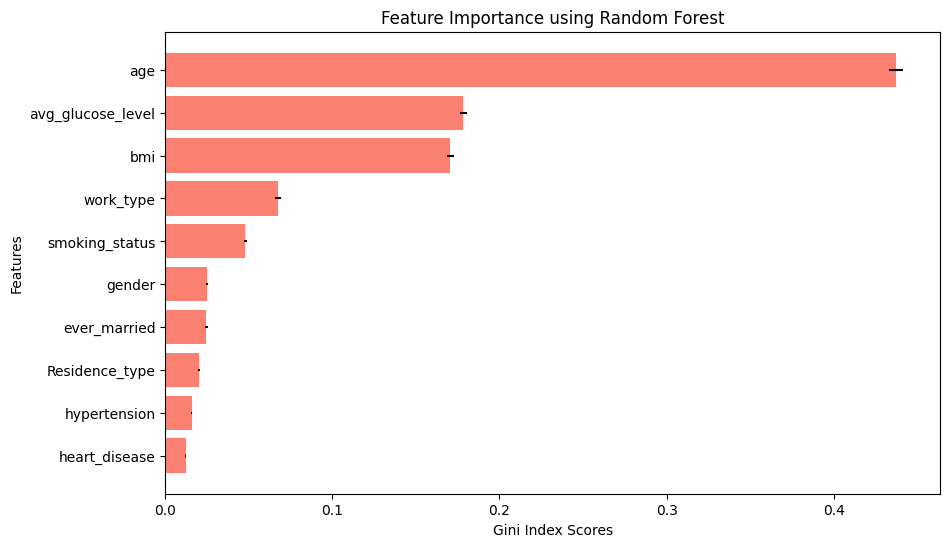

In [21]:
# First evaluation of Global Feature Importance through the mean of Gini Index Criterio

# Define features and target 
X = df.drop('stroke', axis=1)
y = df['stroke']

# Apply SMOTE to balance the classes
smote = SMOTE(random_state=59)
X_smote, y_smote = smote.fit_resample(X, y)

# Initialize a random forest classifier
rf = RandomForestClassifier(criterion = 'gini', random_state=59)

# Set up a nested cross-validation with stratified k-fold
stratified_kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=59)

feature_importances = []

for i, (train_index, test_index) in enumerate(stratified_kfold.split(X_smote, y_smote)):

    print(f"Fold {i+1}...")
    
    # Define train and test
    X_train, X_test = X_smote.iloc[train_index], X_smote.iloc[test_index]
    y_train, y_test = y_smote.iloc[train_index], y_smote.iloc[test_index]
    
    # Fit classifier
    rf.fit(X_train, y_train)
    
    # Append feature importances
    feature_importances.append(rf.feature_importances_)

# Compute mean importance across folds
mean_importances = np.mean(feature_importances, axis=0)
std_importances = np.std(feature_importances, axis=0)

# Sort features by mean importance
sorted_indices = np.argsort(mean_importances)

# Plot feature importances

plt.figure(figsize=(10, 6))

plt.barh(range(len(sorted_indices)), mean_importances[sorted_indices], xerr=std_importances[sorted_indices] , color='salmon')

plt.yticks(range(len(sorted_indices)), [X.columns[i] for i in sorted_indices])
plt.xlabel("Gini Index Scores")
plt.ylabel("Features")
plt.title("Feature Importance using Random Forest")
plt.show()